In [89]:
pip install numpy pandas yfinance matplotlib plotly ipython nbformat nbconvert statsmodels IPython

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [90]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm
from IPython.display import Image;


In [91]:
#You find two stocks that are historically "tied" together (e.g., Coke & Pepsi, or Gold & Gold Miners). When they drift apart, you 
# Short the winner and Long the loser, betting they will snap back like a rubber band.

# calibration pair
tickers = ['GOOGL', 'GOOG','KO','PEP','V','MA','MSTR','COIN','GLD','GDX','SLV','IAU','XOM','CVX']

# 1. Get Data for a Correlated Pair
data = yf.download(tickers, period="10y", auto_adjust=True)


[*********************100%***********************]  14 of 14 completed


In [97]:
data

Price            Close                                                  \
Ticker            COIN         CVX         GDX         GLD        GOOG   
Date                                                                     
2016-02-29         NaN   54.552849   17.574614  118.639999   34.628780   
2016-03-01         NaN   56.311554   16.840069  117.769997   35.672947   
2016-03-02         NaN   56.971874   17.275351  118.680000   35.674927   
2016-03-03         NaN   57.226883   17.973623  120.730003   35.355820   
2016-03-04         NaN   57.488396   17.873869  120.540001   35.279892   
...                ...         ...         ...         ...         ...   
2026-02-20  171.350006  183.929993  106.260002  468.619995  314.899994   
2026-02-23  160.240005  184.910004  110.290001  481.279999  311.690002   
2026-02-24  162.029999  185.339996  110.699997  474.609985  310.920013   
2026-02-25  183.940002  184.220001  111.160004  473.420013  313.029999   
2026-02-26  181.059998  184.160004  113.889999  477.480011  307.149994   

Price                                                                 ...  \
Ticker           GOOGL        IAU         KO          MA        MSTR  ...   
Date                                                                  ...   
2016-02-29   35.592072  23.980000  31.497826   81.890007   16.089001  ...   
2016-03-01   36.830223  23.760000  31.906790   84.885979   17.239000  ...   
2016-03-02   36.696728  23.940001  31.965216   84.688141   16.823999  ...   
2016-03-03   36.305187  24.340000  32.103981   84.546829   17.077999  ...   
2016-03-04   36.237202  24.340000  32.213520   84.838860   16.898001  ...   
...                ...        ...        ...         ...         ...  ...   
2026-02-20  314.980011  95.949997  79.839996  526.409973  131.050003  ...   
2026-02-23  311.489990  98.570000  80.559998  496.029999  123.709999  ...   
2026-02-24  310.899994  97.199997  80.720001  498.000000  124.610001  ...   
2026-02-25  312.899994  96.970001  80.470001  509.390015  135.649994  ...   
2026-02-26  307.380005  97.790001  80.500000  514.770020  133.399994  ...   

Price         Volume                                                   \
Ticker          GOOG     GOOGL       IAU        KO       MA      MSTR   
Date                                                                    
2016-02-29  49622000  45068000   1802800  15049800  4302900   1228000   
2016-03-01  43028000  60112000   4096800  12358300  4967500   2635000   
2016-03-02  32580000  36292000   5760900  12856300  3898300   1136000   
2016-03-03  39160000  40534000   2792500  13134800  4202500   1502000   
2016-03-04  39442000  48516000  11099200  13691500  3181300    925000   
...              ...       ...       ...       ...      ...       ...   
2026-02-20  33663100  53210800  10079400  17175100  2838500  17625400   
2026-02-23  17641200  31423000   8340400  17157700  6312300  18858900   
2026-02-24  15040700  25615600   6546000  16448500  5292900  15352700   
2026-02-25  20209100  29963600   7040800  18086900  4139100  24152100   
2026-02-26  22205100  36153600   5627100  12841100  4843600  18066000   

Price                                              
Ticker          PEP       SLV         V       XOM  
Date                                               
2016-02-29  5955300   4938600   7786100  18903600  
2016-03-01  5160200  20681200   8705300  15730600  
2016-03-02  4180000   9133800   5739100  14094400  
2016-03-03  4856600  10448100   6588300  13216200  
2016-03-04  7067200  18755100   9475300  18402700  
...             ...       ...       ...       ...  
2026-02-20  4811800  86636800   6831100  25908600  
2026-02-23  6801600  94752100  13048000  16073100  
2026-02-24  6319800  56012600   9120200  14185500  
2026-02-25  6832700  64933100   7624200  15225700  
2026-02-26  7218500  51592100   8723000  15624300  

[2514 rows x 70 columns]

## The Hedge Ratio

The Hedge Ratio is a multiplier used in pairs trading to determine the correct size of your position in Stock B relative to Stock A. It ensures that your trade is 'market-neutral'. In pairs trading, you are not betting on the market going up or down; you are betting on the spread (the difference) between two stocks reverting to the mean.

Think of the Hedge Ratio ($\beta$) as the weight that isolates the "spread" from the raw prices:$$\text{Spread}_t = \text{Price}_A(t) - (\beta \times \text{Price}_B(t))$$If $\beta = 1.0$: You buy 1 share of A and short 1 share of B.If $\beta = 3.0$: You buy 1 share of A and short 3 shares of B.If $\beta = 0.5$: You buy 1 share of A and short 0.5 shares of B (or 2 of A for 1 of B).

The standard way to find the hedge ratio is using Ordinary Least Squares (OLS) Linear Regression. You regress the price history of Stock A ($Y$) against Stock B ($X$). $$Y = \alpha + \beta X + \epsilon$$ 
* $Y$: The price of Stock A (Dependent Variable)
* $X$: The price of Stock B (Independent Variable)
* $\alpha$: The intercept $\beta$ (Slope): This is your Hedge Ratio.
* $\epsilon$ (Residual): This is the "Spread" or "Noise" that you are actually trading.


### Example

Let's look at the GLD (Gold ETF) vs. GDX (Gold Miners ETF) pair. Miners are often leveraged plays on gold; they are more volatile.
* Scenario: You regress GDX (Y) against GLD (X).
* Result: You get a slope ($\beta$) of 1.6.
* Meaning: Historically, for every $1 move in GLD, GDX moves $1.60.

To act on a signal, if you buy 100 shares of GDX, you must short 160 shares of GLD to be properly hedged.
* If gold prices tank, your GDX long will lose money fast. 
* However, your larger GLD short will make money fast. 
* Because you used the hedge ratio, these two moves should cancel out the "market risk" of gold falling, leaving you with profit/loss based solely on the idiosyncratic difference between the ETF and the Miners.

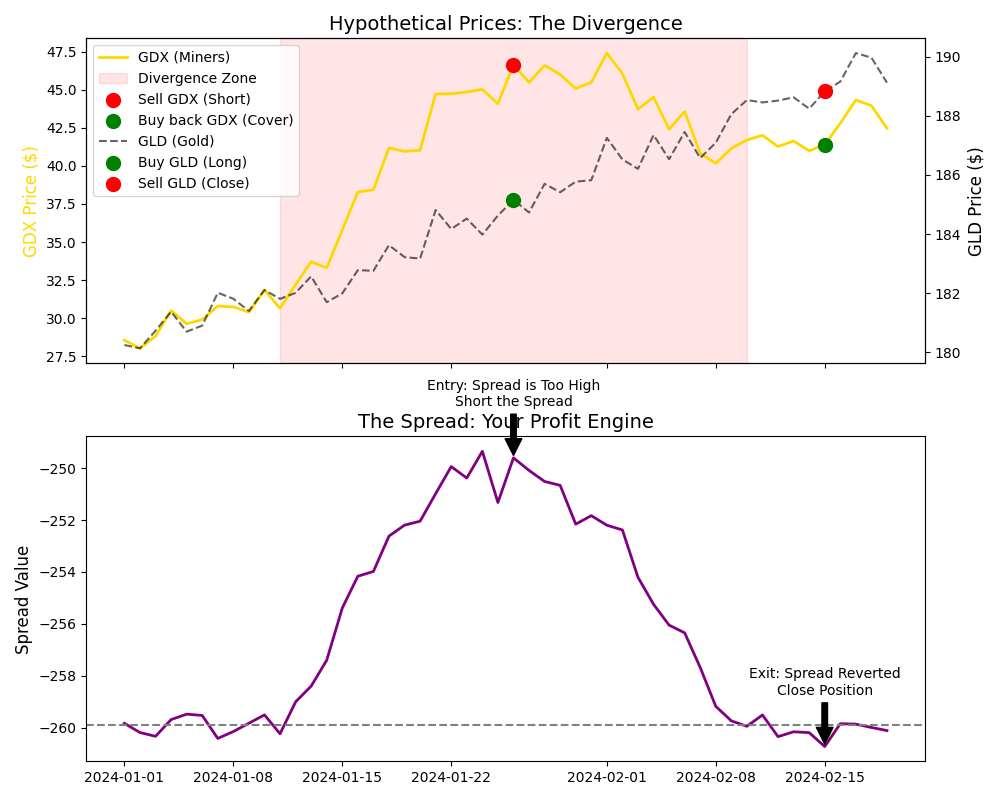

In [92]:
Image(filename='pairs_trading_illustration.png', width=500)

The Scenario (The Setup)
* The Divergence: Suddenly, GDX (the yellow line) spikes up to $46.65, but GLD (the dashed line) only moves slightly to $185.16. 
* The spread has widened—GDX is "too expensive" relative to Gold.
* The Trade: You bet on the spread closing. You Short the expensive one (GDX) and Long the cheap one (GLD).

You decide to trade 1,000 shares of GDX. To stay market neutral, you must buy 1,600 shares of GLD ($1,000 \times 1.6$).

20 days later, the "madness" ends. GDX falls back down to match Gold's reality.
* GDX falls to $41.39 (You win on the short).
* GLD rises slightly to $188.82 (You win on the long).
    * Profit from Shorting GDX: $$\$46,650 (\text{Sold}) - \$41,390 (\text{Bought}) = \mathbf{+\$5,260} $$
    * Profit from Longing GLD: $$\$302,112 (\text{Sold}) - \$296,256 (\text{Bought}) = \mathbf{+\$5,856}$$



But what if Gold had crashed to $150?
* GLD Long: You would have lost massive money on your Gold shares.
* GDX Short: Because Miners are correlated to Gold, GDX would have crashed even harder (e.g., to $20). You would have made massive money on your short.
* Net Result: The profit from the short cancels out the loss from the long, leaving you with the spread profit. This is why it is called "Market Neutral." You don't care where Gold goes; you only care that the relationship between Gold and Miners returns to normal.

In [93]:
# Test for Cointegration (The "Rubber Band" Test)
score, pvalue, _ = coint(data['Close']['GLD'], data['Close']['SLV'])
print(f"Cointegration P-Value: {pvalue}")

Cointegration P-Value: 0.04288462579236625


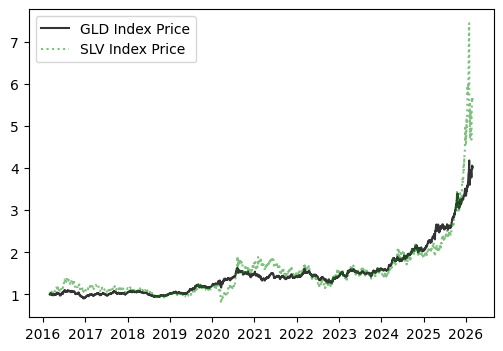

In [102]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 4), sharex=True)
ax1.plot(data.index, data['Close']['GLD']/data['Close']['GLD'].iloc[0], label='GLD Index Price', color='black', alpha=0.8)
ax1.plot(data.index, data['Close']['SLV']/data['Close']['SLV'].iloc[0], label='SLV Index Price', color='green', linestyle=':', alpha=0.5)
ax1.legend(loc='upper left')


In [103]:
model = sm.OLS(data['Close']['GLD'], data['Close']['SLV']).fit()
hedge_ratio = model.params[0]
print(f"Hedge Ratio: {hedge_ratio}")

Hedge Ratio: 7.753283827985406


/var/folders/gp/9snl51jj70dd01jy_yq1bcxr0000gp/T/ipykernel_21400/2184641740.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[0]


In [109]:
spread = pd.DataFrame({
    'close_gld': data['Close']['GLD'],
    'close_slv': data['Close']['SLV'],
    'spread': data['Close']['GLD'] - hedge_ratio * data['Close']['SLV']
})
spread['mean_spread'] = spread['spread'].rolling(window = 30).mean()
spread['std_spread'] = spread['spread'].rolling(window=30).std()
spread['Z_Score'] = (spread['spread'] - spread['mean_spread']) / spread['std_spread']

spread['Signal'] = np.where(spread['Z_Score'] < -2, 1, np.where(spread['Z_Score'] > 2, -1, 0))